<a href="https://colab.research.google.com/github/ShahhhVihaan/MoodMirror/blob/main/model-notebooks/moodmirror_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting drive so we have access to our data in the cloud
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# necessary imports for later
import os, shutil
import keras
import numpy as np
import tensorflow as tf
from keras import layers
from keras.utils import image_dataset_from_directory

In [3]:
# unzipping the directory in google drive that holds our data
!unzip /content/drive/My\ Drive/train_val_test.zip

Archive:  /content/drive/My Drive/train_val_test.zip
 extracting: test.zip                
 extracting: train.zip               
 extracting: val.zip                 


In [ ]:
# unzipping individual folders
!unzip test.zip
!unzip train.zip
!unzip val.zip

In [5]:
# retrieving the data from the appropriate directories
# we use rgb so that we can use the images with VGG19
train_dir = os.path.join("train")
val_dir = os.path.join("val")
test_dir = os.path.join("test")

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='rgb',
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    val_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='rgb',
    batch_size=32)
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='rgb',
    batch_size=32)

Found 44044 files belonging to 7 classes.
Found 12586 files belonging to 7 classes.
Found 6293 files belonging to 7 classes.


# Fast feature extraction
### Data augmentation done in preprocessing stage

In [6]:
# retrieving VGG19
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(48, 48, 3)
)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
import numpy as np

# there are labels associated with each image, which we want to separate from images
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg19.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

# this cell took 3 minutes and 16 seconds to run on V100 GPU

In [8]:
print(train_features.shape)
print(val_features.shape)
print(test_features.shape)

(44044, 1, 1, 512)
(12586, 1, 1, 512)
(6293, 1, 1, 512)


In [9]:
# one-hot encoded labels
print(train_labels[1234])

[0. 0. 0. 0. 0. 0. 1.]


In [10]:
# we pass everything through the convnet, getting inputs
# we pass everything through our last dense layer
inputs = keras.Input(shape=(1, 1, 512))
x = layers.Flatten()(inputs)
x = layers.Dropout(0.25)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# use categorical_crossentropy due to one-hot encoding
model.compile(loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.h5",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

# 2 minutes and 23 seconds to run

Epoch 1/20
1377/1377 [==============================] - 8s 5ms/step - loss: 9.3504 - accuracy: 0.2435 - val_loss: 1.9102 - val_accuracy: 0.2841
Epoch 2/20
  48/1377 [>.............................] - ETA: 4s - loss: 2.1825 - accuracy: 0.2669

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1377/1377 [==============================] - 7s 5ms/step - loss: 2.1544 - accuracy: 0.2655 - val_loss: 1.9977 - val_accuracy: 0.2553
Epoch 3/20
1377/1377 [==============================] - 6s 4ms/step - loss: 2.1202 - accuracy: 0.2707 - val_loss: 1.9598 - val_accuracy: 0.2699
Epoch 4/20
1377/1377 [==============================] - 6s 4ms/step - loss: 2.0991 - accuracy: 0.2735 - val_loss: 2.0458 - val_accuracy: 0.2534
Epoch 5/20
1377/1377 [==============================] - 7s 5ms/step - loss: 2.0942 - accuracy: 0.2761 - val_loss: 2.2966 - val_accuracy: 0.2026
Epoch 6/20
1377/1377 [==============================] - 6s 4ms/step - loss: 2.0900 - accuracy: 0.2744 - val_loss: 1.9529 - val_accuracy: 0.2404
Epoch 7/20
1377/1377 [==============================] - 6s 5ms/step - loss: 2.0856 - accuracy: 0.2761 - val_loss: 2.0820 - val_accuracy: 0.2897
Epoch 8/20
1377/1377 [==============================] - 7s 5ms/step - loss: 2.0902 - accuracy: 0.2755 - val_loss: 1.9592 - val_accuracy: 0.3058
Epo

In [11]:
test_loss, test_acc = model.evaluate(test_features, test_labels, steps=50)
print('test acc:', test_acc)

50/50 [==============================] - 0s 3ms/step - loss: 1.9736 - accuracy: 0.3026
test acc: 0.30255839228630066


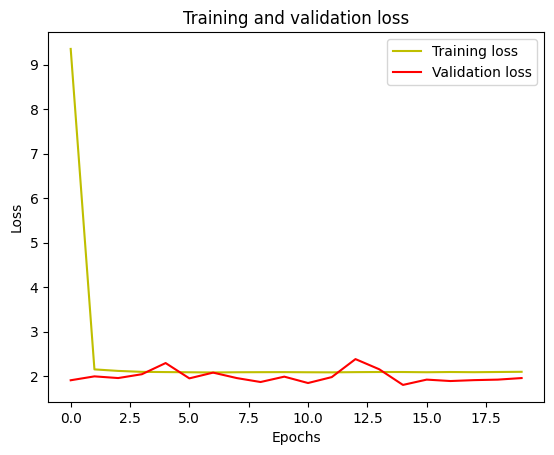

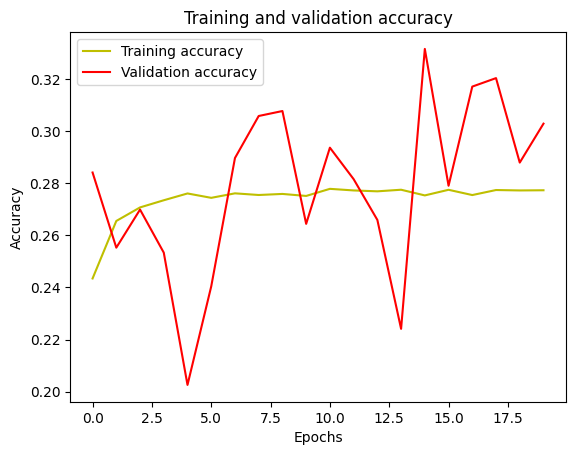

In [12]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history["loss"], "y", label="Training loss")
plt.plot(history.history["val_loss"], "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history["accuracy"], "y", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Fine-tuning pre-trained model (VGG19)

In [13]:
# 1 Add our custom network on top of an already-trained base network.
# 2 Freeze the base network.
# 3 Train the part we added.

conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False
  )
conv_base.trainable = False

data_augmentation = keras.Sequential()

inputs = keras.Input(shape=(48, 48, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg19.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.h5",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
1377/1377 [==============================] - 18s 12ms/step - loss: 33.7682 - accuracy: 0.1605 - val_loss: 13.3819 - val_accuracy: 0.2274
Epoch 2/20
1377/1377 [==============================] - 16s 12ms/step - loss: 25.6175 - accuracy: 0.1944 - val_loss: 11.0043 - val_accuracy: 0.2686
Epoch 3/20
1377/1377 [==============================] - 20s 14ms/step - loss: 21.9000 - accuracy: 0.2199 - val_loss: 9.6702 - val_accuracy: 0.2892
Epoch 4/20
1377/1377 [==============================] - 18s 13ms/step - loss: 19.6006 - accuracy: 0.2300 - val_loss: 8.8801 - val_accuracy: 0.3042
Epoch 5/20
1377/1377 [==============================] - 18s 13ms/step - loss: 17.9572 - accuracy: 0.2324 - val_loss: 8.1827 - val_accuracy: 0.3149
Epoch 6/20
1377/1377 [==============================] - 19s 14ms/step - loss: 16.4725 - accuracy: 0.2433 - val_loss: 7.5096 - val_accuracy: 0.3227
Epoch 7/20
1377/1377 [==============================] - 19s 14ms/step - loss: 15.4449 - accuracy: 0.2428 - val_loss:

In [14]:
# freezing all layers until the fourth from last
# therefore, we are fine-tuning the last three convolutional layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [15]:
model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.h5",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
1377/1377 [==============================] - 23s 14ms/step - loss: 2.0972 - accuracy: 0.2183 - val_loss: 1.7241 - val_accuracy: 0.3097
Epoch 2/30
1377/1377 [==============================] - 21s 15ms/step - loss: 1.7077 - accuracy: 0.3409 - val_loss: 1.6057 - val_accuracy: 0.4001
Epoch 3/30
1377/1377 [==============================] - 21s 15ms/step - loss: 1.5928 - accuracy: 0.3983 - val_loss: 1.5808 - val_accuracy: 0.4151
Epoch 4/30
1377/1377 [==============================] - 23s 16ms/step - loss: 1.5081 - accuracy: 0.4298 - val_loss: 1.5227 - val_accuracy: 0.4240
Epoch 5/30
1377/1377 [==============================] - 21s 15ms/step - loss: 1.4385 - accuracy: 0.4516 - val_loss: 1.4996 - val_accuracy: 0.4320
Epoch 6/30
1377/1377 [==============================] - 21s 15ms/step - loss: 1.3769 - accuracy: 0.4722 - val_loss: 1.4735 - val_accuracy: 0.4407
Epoch 7/30
1377/1377 [==============================] - 23s 17ms/step - loss: 1.3241 - accuracy: 0.4872 - val_loss: 1.4913 -

In [16]:
test_loss, test_acc = model.evaluate(test_dataset, steps=50)
print('test acc:', test_acc)

50/50 [==============================] - 1s 22ms/step - loss: 2.4538 - accuracy: 0.4975
test acc: 0.4975000023841858


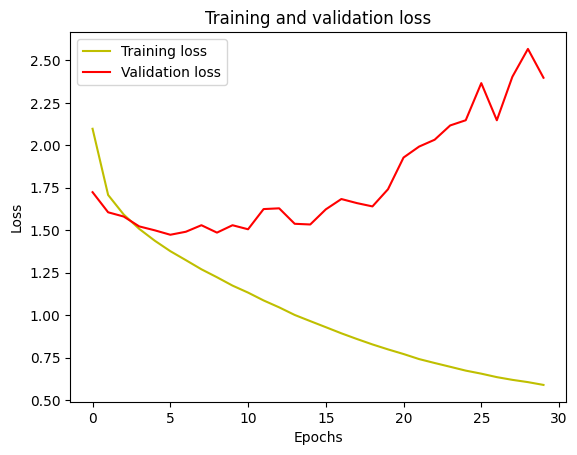

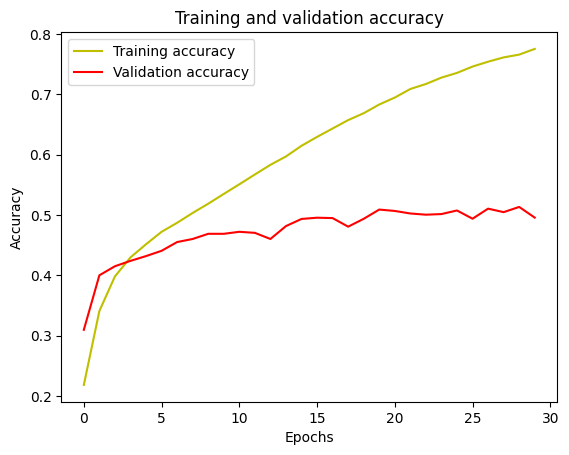

In [17]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history["loss"], "y", label="Training loss")
plt.plot(history.history["val_loss"], "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history["accuracy"], "y", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Here, we can see that while our training accuracy is strong, we are overfitting. This can be seen through the significant difference in the accuracy of the training and validation sets as the number of epochs increases. This is further seen by the fact that the evaluation of the model at the end of training yields an accuracy of only 49.75%, even though the validation accuracy is 77.55% after the last epoch.